# Setup

In [17]:
import numpy as np
from numpy import random
from scipy import stats
import jsonlines
import csv
import pickle
import matplotlib
import matplotlib.pyplot as plt
from time import time
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from classification_tree import Tree

from gensim.models import Word2Vec

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline
matplotlib.style.use('ggplot')

# Dataset

In [2]:
DATASET = 'amazon'

PATH_DATASET = 'datasets/'

In [3]:
from pathlib import Path
filename = PATH_DATASET + 'amazon_co-ecommerce_sample.csv'
filenamejsonl = PATH_DATASET + 'amazon_co-ecommerce_dataset.jsonl'
columns_to_mantain = ['product_name', 'product_description', 'product_information',
                      'amazon_category_and_sub_category']

columns_new_name   = ['name', 'description', 'information' ,'category']

readFile = open(filename, 'r')
reader = csv.reader(readFile)
       
data = list()
for row in reader:
    data.append(row)
readFile.close()

dataset = pd.DataFrame.from_dict(data)
dataset.columns = dataset.loc[0]
dataset = dataset.drop([0])
dataset = dataset.dropna()

dataset = dataset[columns_to_mantain]

dataset.columns = columns_new_name
        
dataset.to_json(filenamejsonl, orient='records', lines=True)

In [4]:
text_field='name'
label_field='category'

dataset = list()
not_labeled = 0
not_text = 0

stopwords_en = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

reader = jsonlines.open(filenamejsonl)

for obj in reader:
    json = dict()
    if len(obj[label_field]) > 0:
        if len(obj[text_field]) > 0:
            text = obj[text_field].lower()
            tokens = tokenizer.tokenize(text)
            filtered_words = filter(lambda token: token not in stopwords_en, tokens)
            text = " ".join(filtered_words)
            json['text'] = text
            json['label'] = obj[label_field].lower()
            dataset.append(json)
        else:
            not_text += 1    
    else:
        not_labeled += 1

reader.close()

print('%d lines skipped (not labeled)' % not_labeled)
print('%d lines skipped (not text)' % not_text)

dataset = pd.DataFrame.from_dict(dataset)

690 lines skipped (not labeled)
0 lines skipped (not text)


In [5]:
dataset.head(5)

,label,text
0,hobbies > model trains & railway sets > rail v...,hornby 2014 catalogue
1,hobbies > model trains & railway sets > rail v...,funkybuys large christmas holiday express fest...
2,hobbies > model trains & railway sets > rail v...,classic toy train set track carriages light en...
3,hobbies > model trains & railway sets > rail v...,hornby coach r4410a br hawksworth corridor 3rd
4,hobbies > model trains & railway sets > rail v...,hornby 00 gauge 0 4 0 gildenlow salt co steam ...


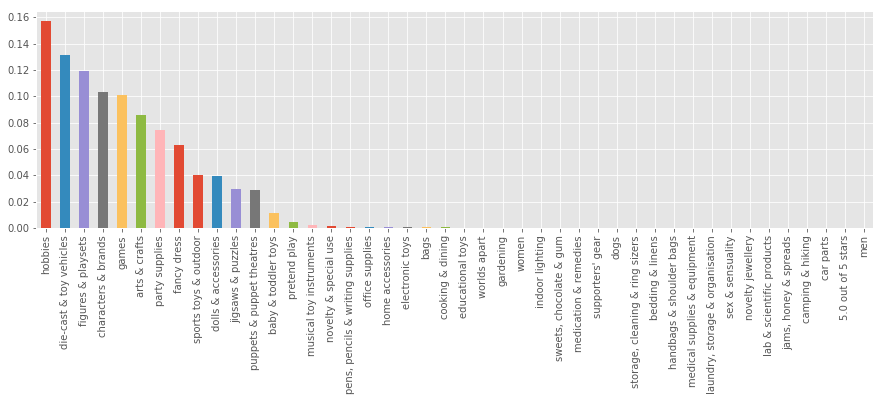

In [6]:
labels = dataset.label.transform(lambda x: x.split(' > ')[0])
labels_freq = labels.value_counts() / labels.count()
labels_freq.plot(kind='bar', figsize=(15, 4))
plt.show()

All labels with minimum 0 samples: 256


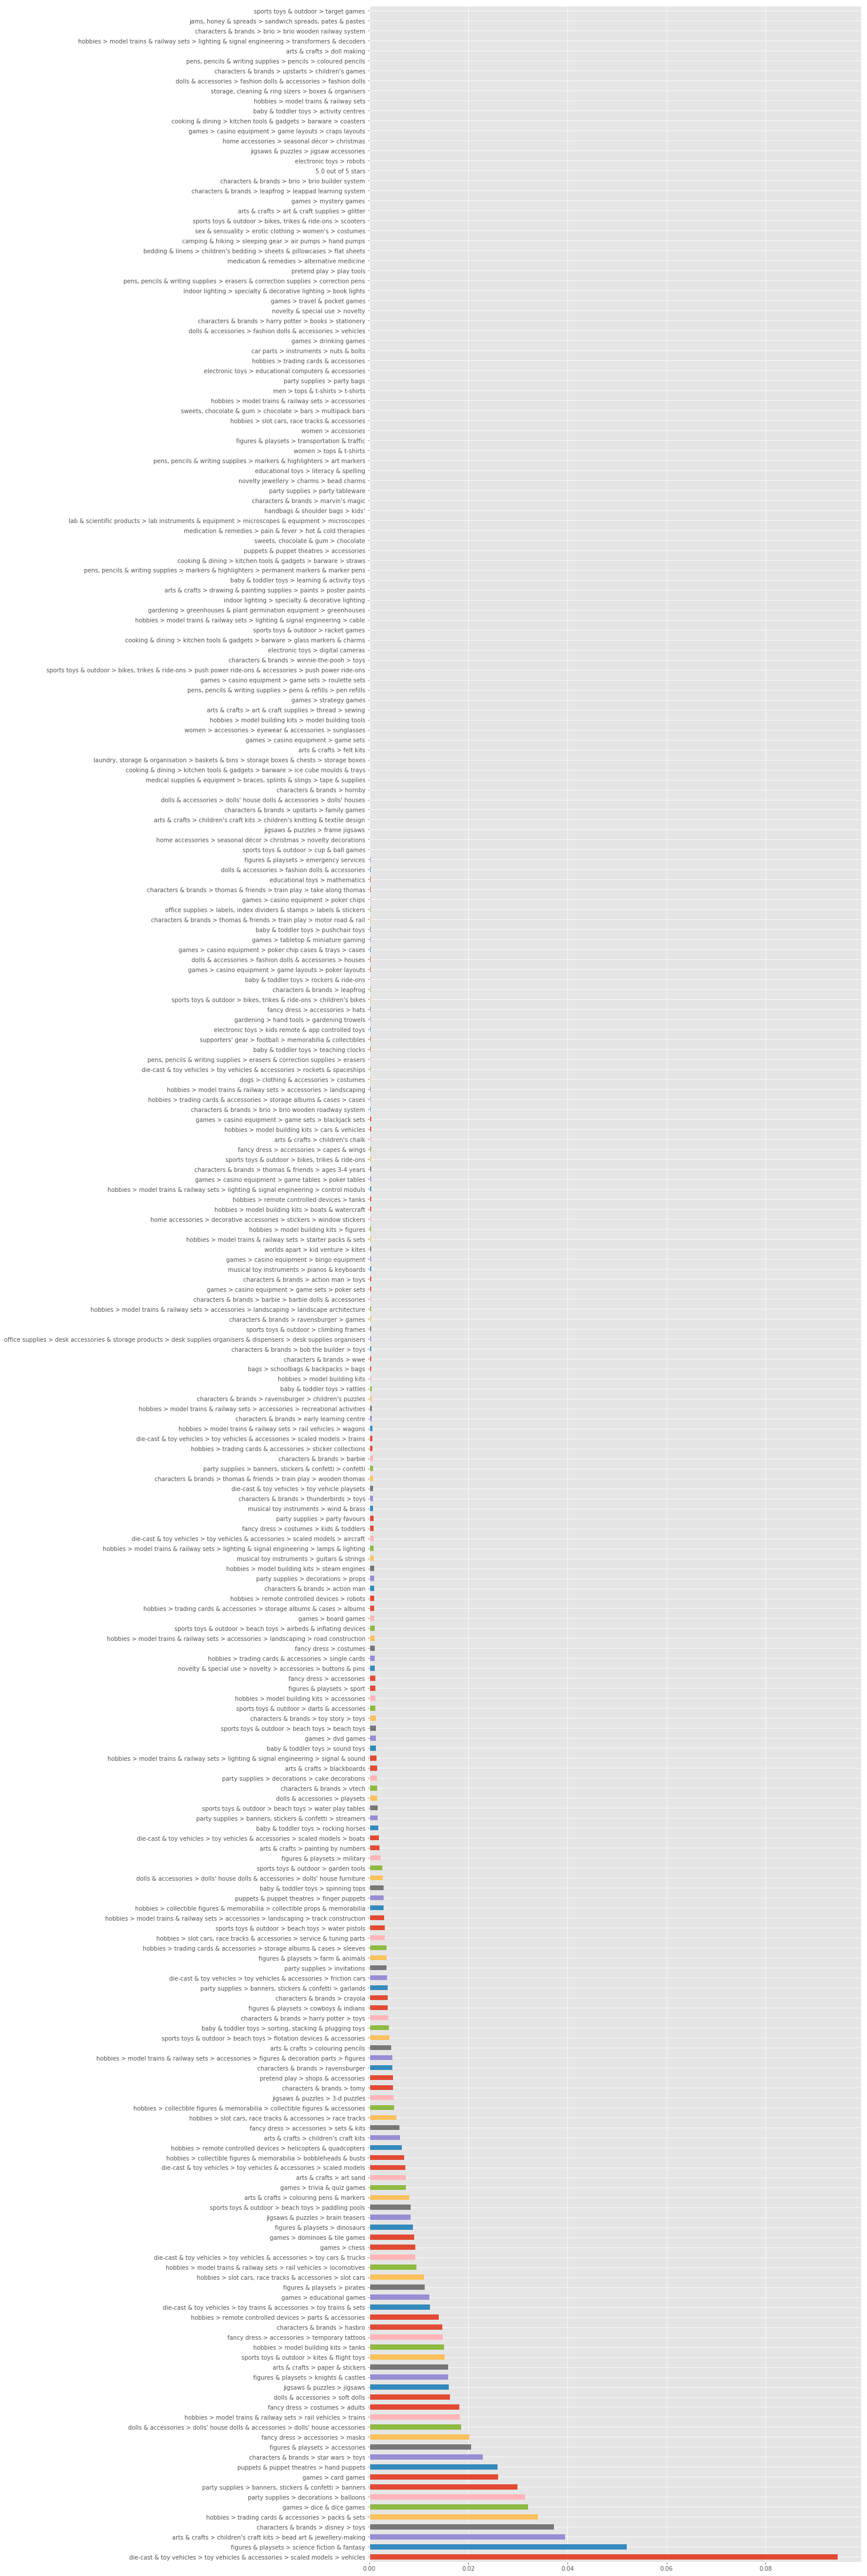

In [7]:
min_samples= 0
group_data = dataset.label.value_counts()
group_data = group_data[group_data >= min_samples]
labels_freq = group_data / dataset.label.count()
print('All labels with minimum %d samples: %d' % (min_samples, labels_freq.count()))
labels_freq.plot(kind='barh', figsize=(15, 80), width=0.5)
plt.show()

In [8]:
max_samples = 1
group_data = dataset.label.value_counts()
group_data = group_data[group_data <= max_samples]
print('All labels with maximum %d sample(s): %d' % (max_samples, group_data.count()))

All labels with maximum 1 sample(s): 85


In [9]:
group_data = dataset.label.value_counts()
group_data = group_data[group_data <= 1]
dataset = dataset[~dataset.label.isin(group_data.index)]

print('Total filtered labels:', dataset.label.unique().size)

Total filtered labels: 171


Text Length Max:  67
Text Length Min:  1
Text Length Mode: 6
Text Length Mean: 8.42
Text Length Std:  4.18
S/W Text Ratio:   8.42


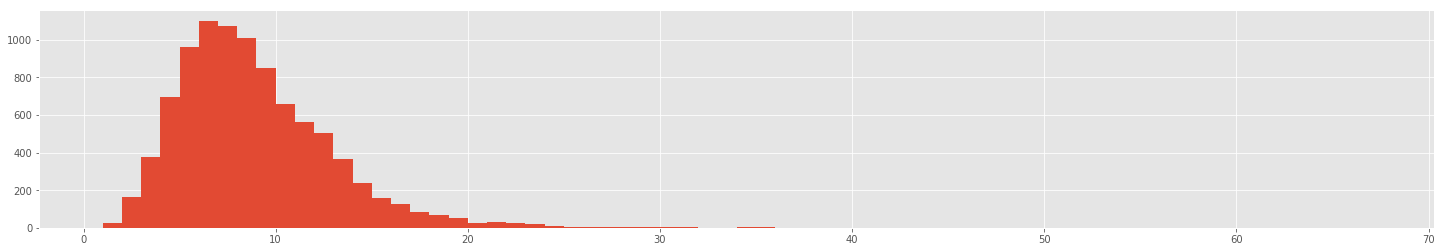

In [13]:
data = dataset.text.transform(lambda x: len(x.split()))

maxL = data.max()
minL = data.min()
mode = data.mode()[0]
mean = data.mean()
std = data.std()
s_w_ratio = dataset.text.count() / mean

print('Text Length Max:  %d' % maxL)
print('Text Length Min:  %d' % minL)
print('Text Length Mode: %d' % mode)
print('Text Length Mean: %.2f'% mean)
print('Text Length Std:  %.2f'% std)
print('S/W Text Ratio:   %.2f'% mean)

plt.figure(figsize=(25,4))
plt.hist(data, bins=maxL-1)
plt.show()

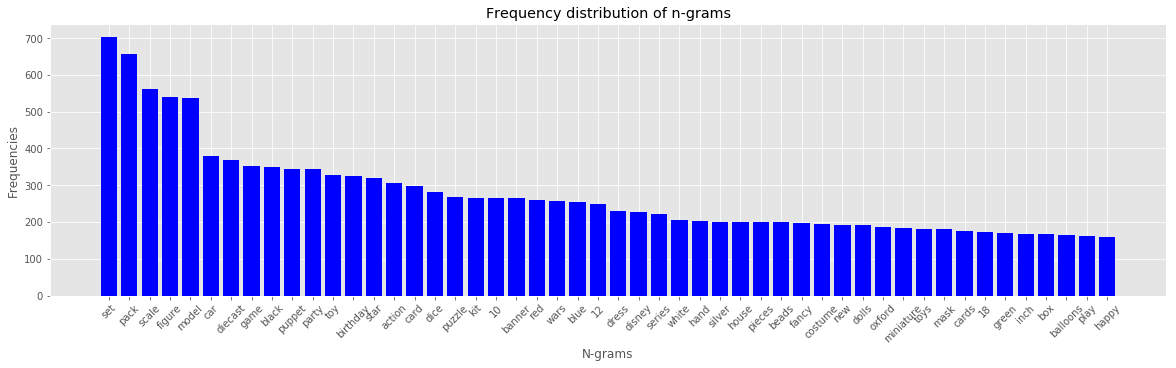

In [14]:
def plot_frequency_distribution_of_ngrams(sample_texts, ngram_range=(1, 2), num_ngrams=50):
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(20,5))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()
    
plot_frequency_distribution_of_ngrams(dataset.text, ngram_range=(1, 2), num_ngrams=50)

# Embedding

### Save Data Models

In [ ]:
MAX_SEQUENCE_LENGTH = data.max

In [ ]:
EMBEDDING_DIM = 100

PATH_DATA_MODELS   = 'data_models/'

FILE_WORD2VEC      = PATH_DATA_MODELS + DATASET + '_' + X_used +'_word2vec_s' + str(EMBEDDING_DIM) + '.model'
FILE_TOKENIZER     = PATH_DATA_MODELS + DATASET + '_' + X_used +'_tokenizer.sav'
FILE_VECTORIZER    = PATH_DATA_MODELS + DATASET + '_' + X_used +'_vectorizer.sav'
FILE_LABEL_ENCODER = PATH_DATA_MODELS + DATASET +'_label_encoder.sav'

### Word2Vec

In [ ]:
sentences = []
for item in dataX:
    split = item.split()
    sentences.append(split)
    
start = time()
word2vec = Word2Vec(sentences, size=EMBEDDING_DIM)
print("Execution Time:", round(time() - start, 2), 's')
print("Number of Word Vectors:", len(list(word2vec.wv.vocab)))

# Save Word2Vec
word2vec.save(FILE_WORD2VEC)

### Tokenizer

In [ ]:
MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(dataX)
print("Number of Tokens:",len(tokenizer.word_counts))

# Save Tokenizer
pickle.dump(tokenizer, open(FILE_TOKENIZER, 'wb'))

### Vectorizer

In [ ]:
MAX_NB_WORDS = 20000
vectorizer  = TfidfVectorizer(max_features=MAX_NB_WORDS, stop_words='english')
vectorizer.fit(dataX)

# Save Vectorizer
pickle.dump(vectorizer, open(FILE_VECTORIZER, 'wb'))

### Label Encoder

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(labels)

# Save Label Encoder 
pickle.dump(le, open(FILE_LABEL_ENCODER, 'wb'))

# Classification Tree

In [18]:
tree = Tree('Root')    
for label in labels:
    split = label.split(' > ')
    tree = tree.populateTree(split, 0)

In [20]:
x_train = dataset.text
y_train = dataset.label
tree.sampleTree(x_train, y_train, 0)
print()

 > Root Samples: 9225 Nodes 26
|   > hobbies Samples: 1457 Nodes 6
|  |   > model trains & railway sets Samples: 383 Nodes 4
|  |  |   > rail vehicles Samples: 264 Nodes 3
|  |  |  |   > trains Samples: 170 Nodes 0
|  |  |  |   > locomotives Samples: 88 Nodes 0
|  |  |  |   > wagons Samples: 6 Nodes 0
|  |  |   > lighting & signal engineering Samples: 24 Nodes 3
|  |  |  |   > lamps & lighting Samples: 8 Nodes 0
|  |  |  |   > signal & sound Samples: 13 Nodes 0
|  |  |  |   > control moduls Samples: 3 Nodes 0
|  |  |   > accessories Samples: 92 Nodes 3
|  |  |  |   > recreational activities Samples: 5 Nodes 0
|  |  |  |   > landscaping Samples: 44 Nodes 3
|  |  |  |  |   > landscape architecture Samples: 4 Nodes 0
|  |  |  |  |   > track construction Samples: 28 Nodes 0
|  |  |  |  |   > road construction Samples: 10 Nodes 0
|  |  |  |   > figures & decoration parts Samples: 43 Nodes 1
|  |  |  |  |   > figures Samples: 43 Nodes 0
|  |  |   > starter packs & sets Samples: 3 Nodes 0
|  

|   > electronic toys Samples: 2 Nodes 1
|  |   > kids remote & app controlled toys Samples: 2 Nodes 0
|   > dolls & accessories Samples: 368 Nodes 4
|  |   > fashion dolls & accessories Samples: 4 Nodes 1
|  |  |   > houses Samples: 2 Nodes 0
|  |   > dolls' house dolls & accessories Samples: 198 Nodes 2
|  |  |   > dolls' house accessories Samples: 172 Nodes 0
|  |  |   > dolls' house furniture Samples: 26 Nodes 0
|  |   > playsets Samples: 15 Nodes 0
|  |   > soft dolls Samples: 151 Nodes 0
|   > educational toys Samples: 2 Nodes 1
|  |   > mathematics Samples: 2 Nodes 0
|   > supporters' gear Samples: 2 Nodes 1
|  |   > football Samples: 2 Nodes 1
|  |  |   > memorabilia & collectibles Samples: 2 Nodes 0
|   > musical toy instruments Samples: 19 Nodes 3
|  |   > guitars & strings Samples: 8 Nodes 0
|  |   > pianos & keyboards Samples: 4 Nodes 0
|  |   > wind & brass Samples: 7 Nodes 0
|   > novelty & special use Samples: 10 Nodes 1
|  |   > novelty Samples: 10 Nodes 1
|  |  |   > a